In [96]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [97]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

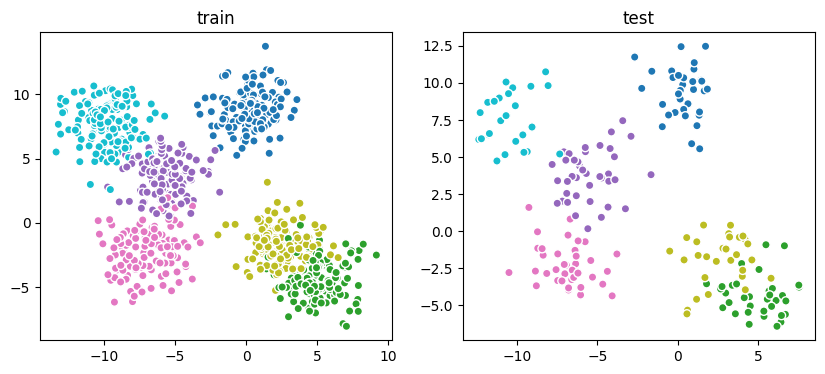

In [98]:
# building the data

X, y = make_blobs(
	n_samples=1000, n_features=2, centers=6, cluster_std=1.5, random_state=23
)

X = torch.tensor(X).to(device).type(torch.float)
y = torch.tensor(y).to(device).type(torch.long)


X_train, X_test, y_train, y_test = train_test_split(
	X, y, random_state=23, test_size=0.2
)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('train')
plt.scatter(X_train.cpu()[:, 0], X_train.cpu()[:, 1], c=y_train.cpu(), cmap='tab10', edgecolors='w')
plt.subplot(1, 2, 2)
plt.title('test')
plt.scatter(X_test.cpu()[:, 0], X_test.cpu()[:, 1], c=y_test.cpu(), cmap='tab10', edgecolors='w')


In [99]:
class MultiClassModel(nn.Module):
	def __init__(self, in_features, out_featers, hidden_units):
		super().__init__()


		self.sequential = nn.Sequential(
			nn.Linear(in_features=in_features, out_features=hidden_units),
			#nn.Tanh(),
			nn.ReLU(),
			nn.Linear(in_features=hidden_units, out_features=hidden_units),
			#nn.Tanh(),
			nn.ReLU(),
			nn.Linear(in_features=hidden_units, out_features=out_featers)
		)


	def forward(self, X: torch.Tensor) -> torch.Tensor:
		return self.sequential(X)



model = MultiClassModel(2, 6, 8).to(device)


In [100]:
model.eval()
with torch.inference_mode():
	y_pred = model(X_test)

y_pred_prob = torch.softmax(y_pred, dim=1)
y_pred = torch.argmax(y_pred_prob, dim=1)
# logits(raw output) => perdiction probability => argmax(int label)
accuracy_score(y_test.cpu(), y_pred.cpu())


0.13

In [101]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-3)


In [107]:
torch.manual_seed(23)
torch.cuda.manual_seed_all(23)
epochs = 8000

for epoch in range(epochs):
	model.train()

	y_logits = model(X_train)

	y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

	loss = loss_fn(y_logits, y_train)
	#loss = loss_fn(torch.softmax(y_logits, dim=1), y_train)

	optimizer.zero_grad()

	loss.backward()

	optimizer.step()

	model.eval()
	with torch.inference_mode():
		y_test_logits = model(X_test)
		y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

		test_loss = loss_fn(y_test_logits, y_test)

	acc = accuracy_score(y_test.cpu(), y_test_pred.cpu())*100
	print(
		f'{epoch = :0>4}\t{loss = :.3f}\t{test_loss = :.3f}\taccuracy={acc:.2f}%'
	) if epoch%(1 if epochs<10 else int(epochs*0.1)) == 0 else ...


epoch = 0000	loss = 0.290	test_loss = 0.302	accuracy=88.50%
epoch = 0800	loss = 0.286	test_loss = 0.298	accuracy=89.00%
epoch = 1600	loss = 0.282	test_loss = 0.294	accuracy=89.00%
epoch = 2400	loss = 0.278	test_loss = 0.290	accuracy=88.50%
epoch = 3200	loss = 0.274	test_loss = 0.286	accuracy=88.50%
epoch = 4000	loss = 0.271	test_loss = 0.283	accuracy=88.00%
epoch = 4800	loss = 0.267	test_loss = 0.279	accuracy=88.50%
epoch = 5600	loss = 0.263	test_loss = 0.275	accuracy=89.00%
epoch = 6400	loss = 0.260	test_loss = 0.272	accuracy=89.00%
epoch = 7200	loss = 0.257	test_loss = 0.269	accuracy=89.00%


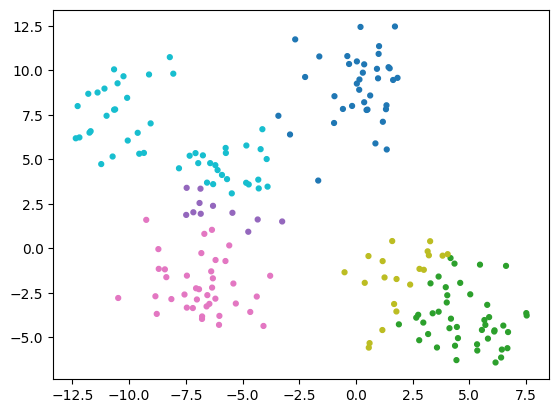

In [103]:
model.eval()
with torch.inference_mode():
	y_pred = model(X_test)
y_pred = y_pred.softmax(dim=1).argmax(dim=1)

plt.scatter(
	X_test.cpu()[:, 0], X_test.cpu()[:, 1], c=y_pred.cpu(), s=12, cmap=plt.cm.tab10
)


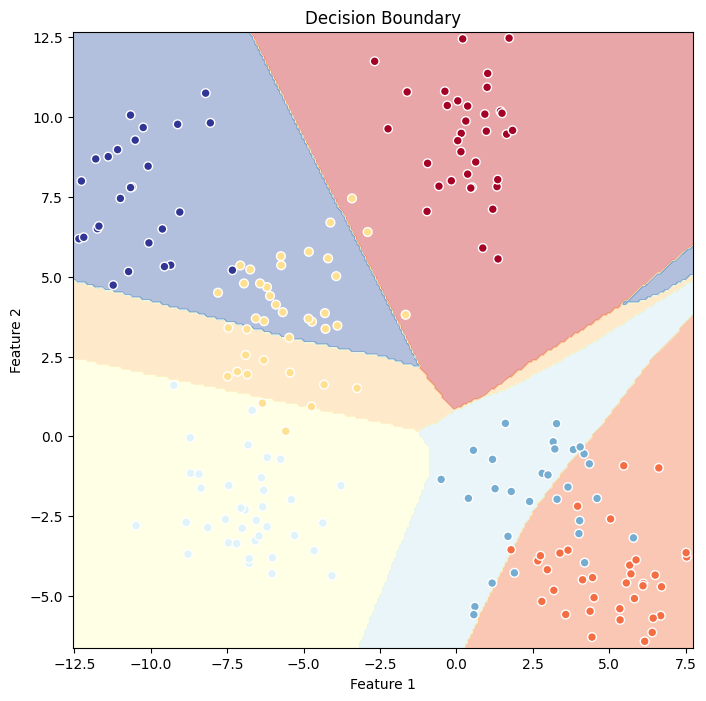

In [104]:
from helper_functions import plot_decision_boundary
plot_decision_boundary(model=model, X=X_test, y=y_test)
